In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl
import sacc
from tjpcov import wigner_transform, bin_cov, parse
d2r=np.pi/180


In [3]:
ccl.__version__

'2.0.0rc3'

In [4]:
filename='./des_y1_3x2pt/des_y1_3x2pt.yaml'
inp_config,inp_dat=parse(filename)

Module 'firecrown.priors' for analysis 'priors' cannot be imported!
Module 'firecrown.ccl.two_point' for analysis 'two_point' cannot be imported!


In [5]:
# cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96,transfer_function='boltzmann_class')
cosmo_param_names=['Omega_c', 'Omega_b', 'h', 'sigma8', 'n_s' ,'transfer_function']
cosmo_params={name:inp_config['parameters'][name] for name in cosmo_param_names}
cosmo = ccl.Cosmology(**cosmo_params)

In [6]:
inp_config['two_point']['sacc_file']

'./des_y1_3x2pt/des_y1_3x2pt_sacc_data.fits'

In [7]:
twopoint_data = sacc.Sacc.load_fits(inp_config['two_point']['sacc_file']) #FROM FIRECROWN EXAMPLE.

In [8]:
#FIXME: f_sky, ell_bins and th_bins should be passed by sacc. ell0 and th can be decided based on binning or can also be passed by sacc.
twopoint_data.metadata['fsky']=0.3
twopoint_data.metadata['ell']=np.arange(2,500)
twopoint_data.metadata['ell_bins']=np.arange(2,500,20)
th_min=2.5/60 # in degrees
th_max=250./60
n_th_bins=20
twopoint_data.metadata['th_bins']=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)

th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,n_th_bins*30) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
twopoint_data.metadata['th']=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(twopoint_data.metadata['th_bins'][1:]+twopoint_data.metadata['th_bins'][:-1])

In [9]:
#The spin based factor to decide the wigner transform. Based on spin of tracers. Sometimes we may use s1_s2 to denote these factors
WT_factors={}
WT_factors['lens','source']=(0,2)
WT_factors['source','lens']=(2,0) #same as (0,2)
WT_factors['source','source']={'plus':(2,2),'minus':(2,-2)}
WT_factors['lens','lens']=(0,0)

In [10]:
#### Wigner Transform setup... 
WT_kwargs={'l': twopoint_data.metadata['ell'],'theta': twopoint_data.metadata['th']*d2r,'s1_s2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 193 ms, sys: 267 ms, total: 460 ms
Wall time: 1.72 s


In [11]:
len(twopoint_data.get_tracer_combinations())

35

In [12]:
twopoint_data.get_data_types()

['galaxy_density_xi',
 'galaxy_shearDensity_xi_t',
 'galaxy_shear_xi_minus',
 'galaxy_shear_xi_plus']

In [13]:
#this function will generate and return CCL_tracer objects and also compute the noise for all the tracers
def get_tracer_info(two_point_data={}):
    ccl_tracers={}
    tracer_Noise={}
    for tracer in twopoint_data.tracers:
        tracer_dat=twopoint_data.get_tracer(tracer)
        z= tracer_dat.z
        #FIXME: Following should be read from sacc dataset.
        Ngal = 26. #arc_min^2
        sigma_e=.26
        b = 1.5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
        AI = .5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
        Ngal=Ngal*3600/d2r**2
        
        dNdz = tracer_dat.nz
        dNdz/=(dNdz*np.gradient(z)).sum()
        dNdz*=Ngal
        
        if 'source' in tracer or 'src' in tracer:  
            ccl_tracers[tracer]=ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz),ia_bias=(z,AI)) #CCL automatically normalizes dNdz
            tracer_Noise[tracer]=sigma_e**2/Ngal
        elif 'lens' in tracer:
            tracer_Noise[tracer]=1./Ngal
            ccl_tracers[tracer]=ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    return ccl_tracers,tracer_Noise

In [14]:
def get_cov_WT_spin(tracer_comb=None):
#     tracers=tuple(i.split('_')[0] for i in tracer_comb)
    tracers=[]
    for i in tracer_comb:
        if 'lens' in i:
            tracers+=['lens']
        if 'src' in i:
            tracers+=['source']
    return WT_factors[tuple(tracers)]

In [15]:
#compute a single covariance matrix for a given pair of C_ell or xi.  
def cl_gaussian_cov(tracer_comb1=None,tracer_comb2=None,ccl_tracers=None,tracer_Noise=None,two_point_data=None,do_xi=False,
                    xi_plus_minus1='plus',xi_plus_minus2='plus'):  
    #fsky should be read from the sacc
    #tracers 1,2,3,4=tracer_comb1[0],tracer_comb1[1],tracer_comb2[0],tracer_comb2[1]
    ell=two_point_data.metadata['ell']
    cl={}
    cl[13] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[0]], ell)
    cl[24] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[1]], ell)
    cl[14] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[1]], ell)
    cl[23] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[0]], ell)
    
    SN={}
    SN[13]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[0]  else 0
    SN[24]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[1]  else 0
    SN[14]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[1]  else 0
    SN[23]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[0]  else 0
    
    if do_xi:
        norm=np.pi*4*two_point_data.metadata['fsky']
    else: #do c_ell
        norm=(2*ell+1)*np.gradient(ell)*two_point_data.metadata['fsky']

    coupling_mat={}
    coupling_mat[1324]=np.eye(len(ell)) #placeholder
    coupling_mat[1423]=np.eye(len(ell)) #placeholder
    
    cov={}
    cov[1324]=np.outer(cl[13]+SN[13],cl[24]+SN[24])*coupling_mat[1324]
    cov[1423]=np.outer(cl[14]+SN[14],cl[23]+SN[23])*coupling_mat[1423]
    
    cov['final']=cov[1423]+cov[1324]
    
    if do_xi:
        s1_s2_1=get_cov_WT_spin(tracer_comb=tracer_comb1)
        s1_s2_2=get_cov_WT_spin(tracer_comb=tracer_comb2)
        if isinstance(s1_s2_1,dict):
            s1_s2_1=s1_s2_1[xi_plus_minus1] 
        if isinstance(s1_s2_2,dict):
            s1_s2_2=s1_s2_2[xi_plus_minus2] 
        th,cov['final']=WT.projected_covariance2(l_cl=ell,s1_s2=s1_s2_1, s1_s2_cross=s1_s2_2,
                                                      cl_cov=cov['final'])

    cov['final']/=norm
    
    if do_xi:
        thb,cov['final_b']=bin_cov(r=th/d2r,r_bins=two_point_data.metadata['th_bins'],cov=cov['final']) 
    else:
        if two_point_data.metadata['ell_bins'] is not None:
            lb,cov['final_b']=bin_cov(r=ell,r_bins=two_point_data.metadata['ell_bins'],cov=cov['final']) 
            
#     cov[1324]=None #if want to save memory
#     cov[1423]=None #if want to save memory
    return cov

In [16]:
#compute all the covariances and then combine them into one single giant matrix
def get_all_cov(two_point_data={},do_xi=False):
    #FIXME: Only input needed should be two_point_data, which is the sacc data file. Other parameters should be included within sacc and read from there.
    ccl_tracers,tracer_Noise=get_tracer_info(two_point_data=two_point_data)
    tracer_combs=two_point_data.get_tracer_combinations()# we will loop over all these
    N2pt=len(tracer_combs)
    if two_point_data.metadata['ell_bins'] is not None:
        Nell_bins=len(two_point_data.metadata['ell_bins'])-1
    else:
        Nell_bins=len(two_point_data.metadata['ell'])
    if do_xi:
        Nell_bins=len(two_point_data.metadata['th_bins'])-1
    cov_full=np.zeros((Nell_bins*N2pt,Nell_bins*N2pt))
    for i in np.arange(N2pt):
        print("{}/{}".format(i+1, N2pt))
        tracer_comb1=tracer_combs[i]
        indx_i=i*Nell_bins
        for j in np.arange(i,N2pt):
            tracer_comb2=tracer_combs[j]
            indx_j=j*Nell_bins
            cov_ij=cl_gaussian_cov(tracer_comb1=tracer_comb1,tracer_comb2=tracer_comb2,ccl_tracers=ccl_tracers,
                                        tracer_Noise=tracer_Noise,do_xi=do_xi,two_point_data=two_point_data)
            if do_xi or two_point_data.metadata['ell_bins'] is not None:
                cov_ij=cov_ij['final_b']
            else:
                cov_ij=cov_ij['final']
            cov_full[indx_i:indx_i+Nell_bins,indx_j:indx_j+Nell_bins]=cov_ij
            cov_full[indx_j:indx_j+Nell_bins,indx_i:indx_i+Nell_bins]=cov_ij.T
    return cov_full

In [17]:
#C_ell covariance
cov_cl=get_all_cov(two_point_data=twopoint_data,do_xi=False)
#xi covariance .... right now shear-shear is xi+ only. xi- needs to be added in the loops.
cov_xi=get_all_cov(two_point_data=twopoint_data,do_xi=True)

1/35
2/35
3/35
4/35
5/35
6/35
7/35
8/35
9/35
10/35
11/35
12/35
13/35
14/35
15/35
16/35
17/35
18/35
19/35
20/35
21/35
22/35
23/35
24/35
25/35
26/35
27/35
28/35
29/35
30/35
31/35
32/35
33/35
34/35
35/35
1/35
2/35
3/35
4/35
5/35
6/35
7/35
8/35
9/35
10/35
11/35
12/35
13/35
14/35
15/35
16/35
17/35
18/35
19/35
20/35
21/35
22/35
23/35
24/35
25/35
26/35
27/35
28/35
29/35
30/35
31/35
32/35
33/35
34/35
35/35


(0.0, 840.0, 0.0, 840.0)

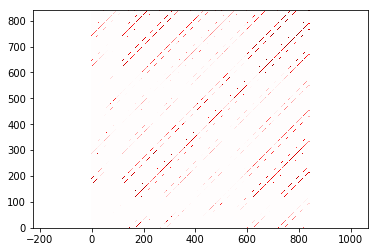

In [21]:
err=np.sqrt(np.diag(cov_cl))
corr_m=cov_cl/np.outer(err,err)
pcolor(corr_m,vmin=-1,vmax=1,cmap='seismic')
axis('equal')

(0.0, 700.0, 0.0, 700.0)

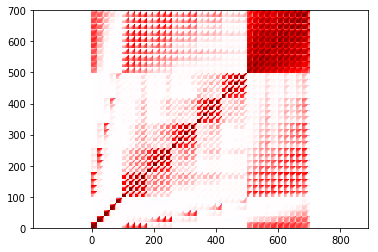

In [22]:
err=np.sqrt(np.diag(cov_xi))
corr_m=cov_xi/np.outer(err,err)
pcolor(corr_m,vmin=-1,vmax=1,cmap='seismic')
axis('equal')